# **Airline Passenger Satisfaction - XAI techniques**


## **Group XXX**
- Athos Freitas - up202108792
- Félix Martins - up202108837
- Luís Du - up202105385

## **Table of contents**

- [Task 1. Dataset and Learning Task](#task-1-dataset-and-learning-task)
  - [1.1. About this dataset](#11-about-this-dataset)
  - [1.2. Data Preprocessing](#12-data-preprocessing)
  - [1.3. Principal Component Analysis (PCA)](#13-principal-component-analysis-pca)
  - [1.4. t-distributed Stochastic Neighbor Embedding (TSNE)](#14-t-distributed-stochastic-neighbor-embedding)
  - [1.5. Correlation Matrix](#15-correlation-matrix)
  
- [Task 2. In-Modeling Explanations](#task-2-in-modeling-explanations)
  - [2.1. Glass Box Model - Decision Tree with depth 3](#21-glass-box-model---decision-tree-with-depth-3)
  - [2.2. Decision Tree Visualization](#22-decision-tree-visualization)
  - [2.3. Feature importance](#23-feature-importance)
  
- [Task 3. Post-Modeling Explanations](#task-3-post-modeling-explanations)
  - [Black box model - XGBoost](#black-box-model---xgboost)
  - [Fine tuning model](#fine-tuning-model)

## **Task 1: Dataset and Learning Task**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
df = pd.read_csv('airline_passenger_satisfaction.csv')

### **1.1. About this dataset**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 24 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   ID                                      129880 non-null  int64  
 1   Gender                                  129880 non-null  object 
 2   Age                                     129880 non-null  int64  
 3   Customer Type                           129880 non-null  object 
 4   Type of Travel                          129880 non-null  object 
 5   Class                                   129880 non-null  object 
 6   Flight Distance                         129880 non-null  int64  
 7   Departure Delay                         129880 non-null  int64  
 8   Arrival Delay                           129487 non-null  float64
 9   Departure and Arrival Time Convenience  129880 non-null  int64  
 10  Ease of Online Booking                  1298

In [4]:
df['Satisfaction'].value_counts()

Satisfaction
Neutral or Dissatisfied    73452
Satisfied                  56428
Name: count, dtype: int64

### **1.2. Data preprocessing**

In [5]:
class RemoveHighlyCorrelated(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.features_to_remove = []

    def transform(self, X, y=None):
        for feature in self.features_to_remove:
            X.drop(feature, axis=1, inplace=True)
        return X

    def fit(self, X, y=None):
        for pair in self.get_highly_correlated_pairs(X):
            feature = self.get_lowest_variance_feature(pair, X)
            self.features_to_remove.append(feature)
        return self
    
    def get_highly_correlated_pairs(self, X):
        pairs_value = X.corr().unstack()
        high_corr_pairs = pairs_value[(pairs_value > self.threshold) & (pairs_value < 1)].sort_values(ascending=False)
        return self.remove_duplicates(high_corr_pairs)
    
    def remove_duplicates(self, pairs):
        unique_pairs = set()
        filtered_pairs = {}
        for index, value in pairs.items():
            pair = tuple(sorted(index))
            if pair not in unique_pairs:
                unique_pairs.add(pair)
                filtered_pairs[index] = value
        return filtered_pairs.keys()
    
    def get_lowest_variance_feature(self, pair, X):
        feature1, feature2 = pair
        return feature1 if X[feature1].var() < X[feature2].var() else feature2
    
    def get_features_to_remove(self):
        return self.features_to_remove

In [6]:
df.drop("ID", axis=1, inplace=True)
df.dropna(axis=0, how='any', subset=None, inplace=True)
df['Satisfaction'] = df['Satisfaction'].map({'Neutral or Dissatisfied': 0, 'Satisfied': 1})

In [7]:
categorical_columns = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
numerical_columns = df.select_dtypes(include=['int64', 'float64']).drop("Satisfaction", axis=1).columns.tolist()

numerical_transformer = Pipeline(
    steps=[
        ('remove_corr', RemoveHighlyCorrelated()),
        ('scaler', StandardScaler()),   
    ]
)
                                
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ],
    remainder='passthrough'
)

X = df.drop('Satisfaction', axis=1)
y = df['Satisfaction']

### **1.3. Principal Component Analysis (PCA)**

In [8]:
X_processed = preprocessor.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

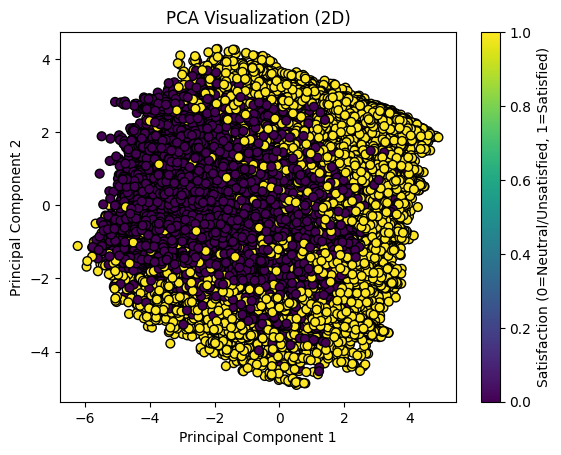

In [9]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y,
            cmap='viridis', edgecolor='k', s=40)
plt.title("PCA Visualization (2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Satisfaction (0=Neutral/Unsatisfied, 1=Satisfied)')
plt.show()

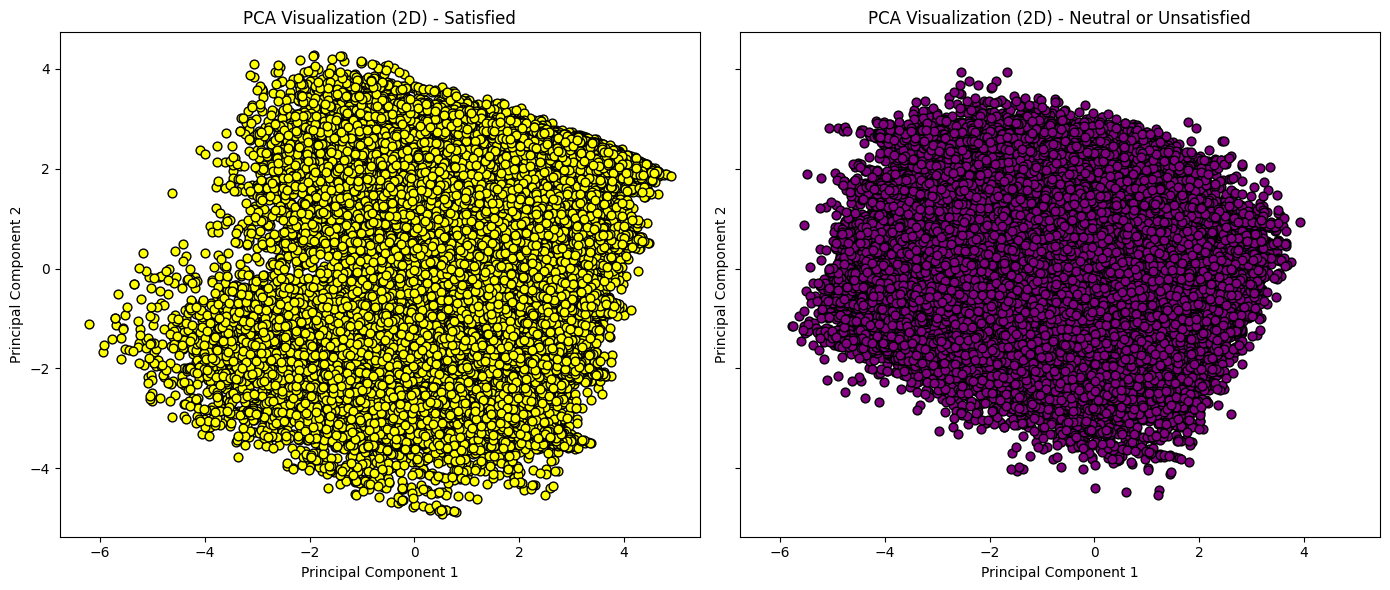

In [10]:
X_pca_sat = X_pca[df['Satisfaction'] == 1]
X_pca_unsat = X_pca[df['Satisfaction'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

axes[0].scatter(X_pca_sat[:, 0], X_pca_sat[:, 1], c = "yellow",
             edgecolor='k', s=40)
axes[0].set_title("PCA Visualization (2D) - Satisfied")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")

axes[1].scatter(X_pca_unsat[:, 0], X_pca_unsat[:, 1], c = 'purple',
            edgecolor='k', s=40)
axes[1].set_title("PCA Visualization (2D) - Neutral or Unsatisfied")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")

plt.tight_layout()
plt.show()

### **1.4. t-distributed Stochastic Neighbor Embedding (TSNE)**

In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=1000, n_iter=1000, n_jobs=-1)

sample_df, _ = train_test_split(df, stratify=df["Satisfaction"], test_size=0.9, random_state=42)
sample_X = sample_df.drop("Satisfaction", axis=1)

sample_X_processed = preprocessor.transform(sample_X)

X_tsne = tsne.fit_transform(sample_X_processed)

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=sample_df['Satisfaction'], cmap='viridis', s=10, alpha=0.7)
plt.colorbar(label='Satisfaction (0=Neutral/Unsatisfied, 1=Satisfied)')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

### **1.5. Correlation Matrix**

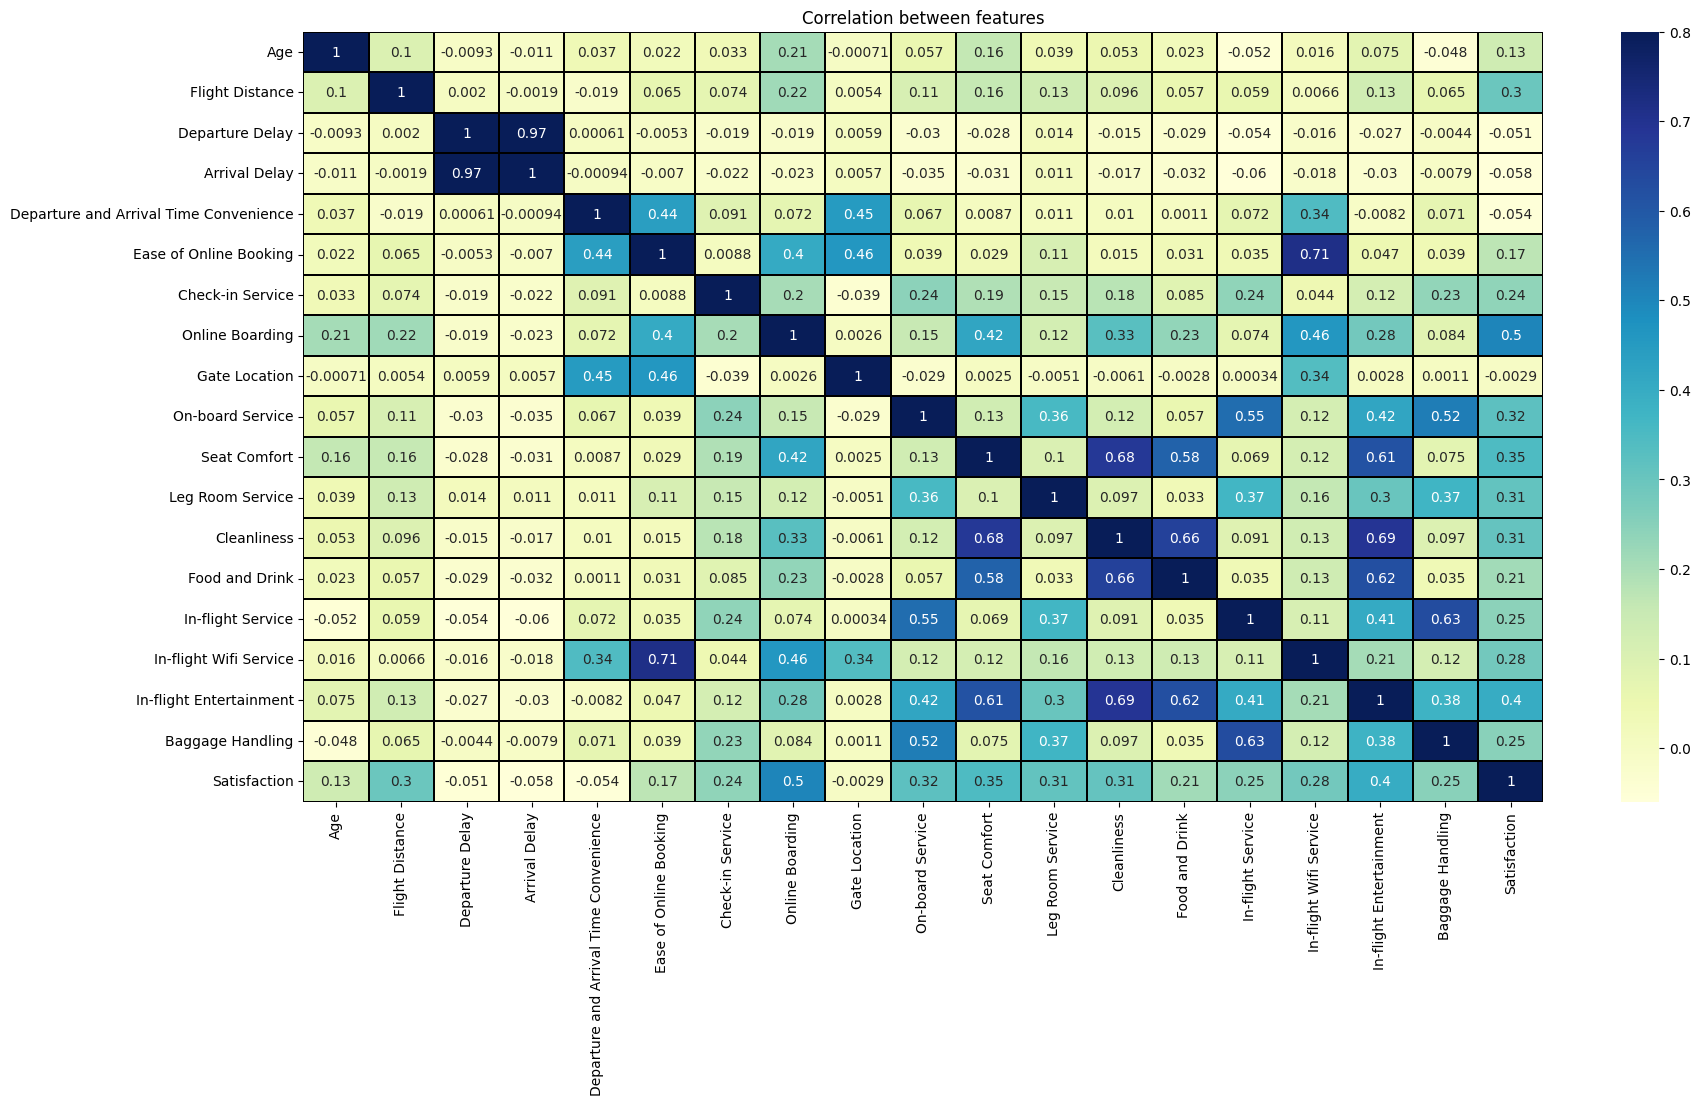

In [13]:
correlation_matrix = df.select_dtypes(include=['int64', 'float64']).corr()

plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix,  vmax=0.8, linewidth=0.01, annot = True, cmap='YlGnBu', linecolor ='black')
plt.title('Correlation between features')
plt.show()

---

## **Task 2: In-Modeling Explanations**

### **2.1. Glass Box Model - Decision Tree with depth 3**

In [ ]:
tree_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_columns),
        ('remove_corr', RemoveHighlyCorrelated(), numerical_columns)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree_clf = DecisionTreeClassifier(random_state=42, max_depth=3)

model = Pipeline(steps=[
    ('preprocessor', tree_preprocessor),
    ('classifier', tree_clf)
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Customer Type',
                                                   'Type of Travel', 'Class']),
                                                 ('remove_corr',
                                                  RemoveHighlyCorrelated(),
                                                  ['Age', 'Flight Distance',
                                                   'Departure Delay',
                                                   'Arrival Delay',
                                                   'Departure and Arrival Time '
                                                   'Convenience',
                                                   'Ease of Online Booking',
                                                   'Check-in Service',
                                                   'Online Boarding',
                                                   'Gate Location',
                                                   'On-board Service',
                                                   'Seat Comfort',
                                                   'Leg Room Service',
                                                   'Cleanliness',
                                                   'Food and Drink',
                                                   'In-flight Service',
                                                   'In-flight Wifi Service',
                                                   'In-flight Entertainment',
                                                   'Baggage Handling'])])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=3, random_state=42))])

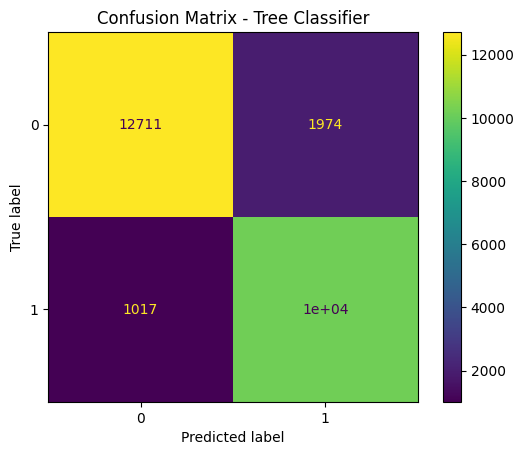

              precision    recall  f1-score   support

           0       0.93      0.87      0.89     14685
           1       0.84      0.91      0.87     11213

    accuracy                           0.88     25898
   macro avg       0.88      0.89      0.88     25898
weighted avg       0.89      0.88      0.88     25898



In [16]:
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title('Confusion Matrix - Tree Classifier')
plt.show()

print(classification_report(y_test, y_pred))

### **2.2. Decision Tree Visualization**

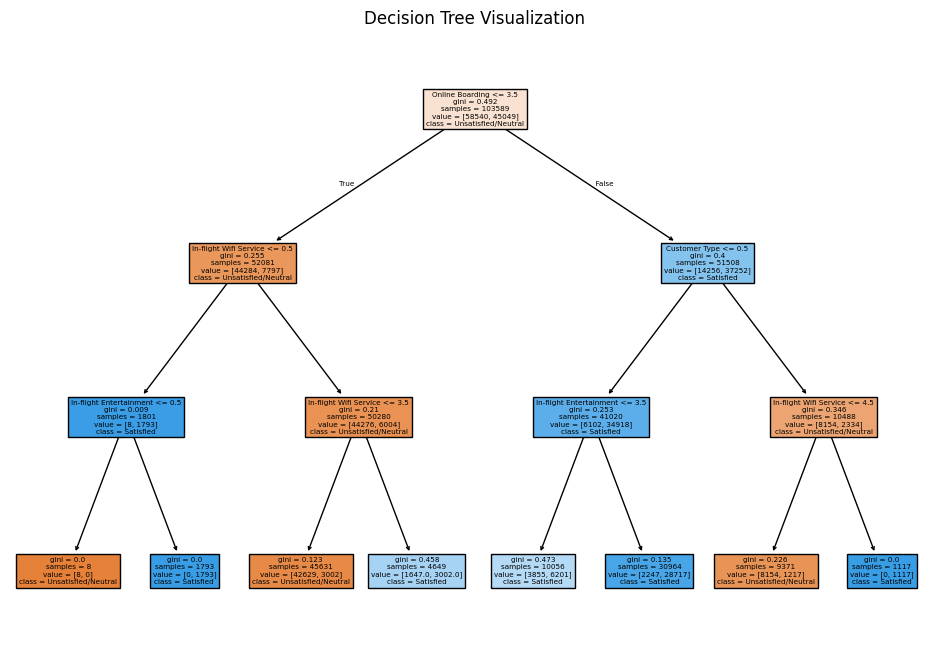

In [17]:
plt.figure(figsize=(12, 8))
plot_tree(tree_clf, feature_names=df.columns, class_names=['Unsatisfied/Neutral', 'Satisfied'], filled=True)
plt.title("Decision Tree Visualization")
plt.show()

### **2.3. Feature importance**

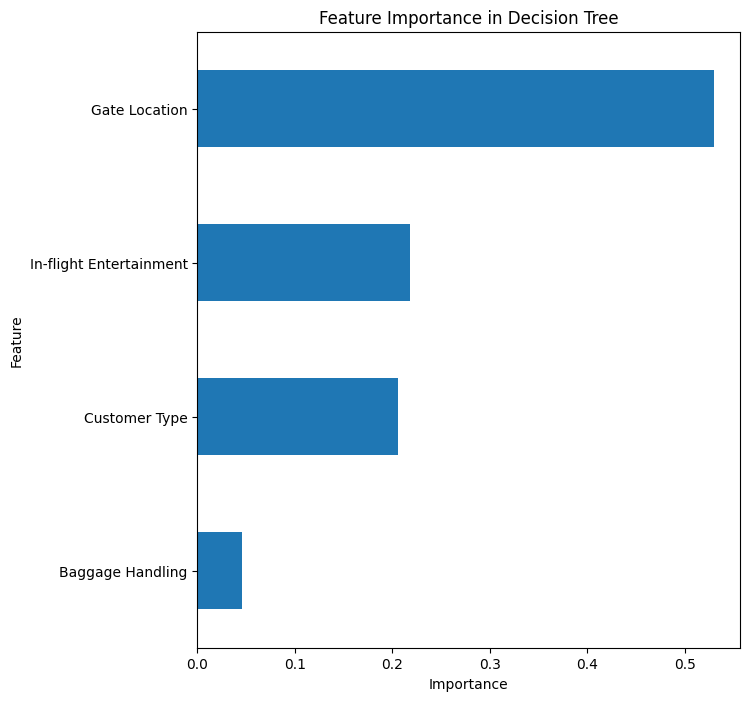

In [18]:
importances = pd.Series(tree_clf.feature_importances_, index=df.columns.drop('Arrival Delay'))
importances = importances[importances > 0]
importances = importances.sort_values() 
importances.plot(kind='barh',figsize=(7,8))
plt.title("Feature Importance in Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

---

## **Task 3. Post-Modeling Explanations**

### **Black box model - XGBoost**

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('remove_corr',
                                                                   RemoveHighlyCorrelated()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Flight Distance',
                                                   'Departure Delay',
                                                   'Arrival Delay',
                                                   'Departure and Arrival Time '
                                                   'Convenience',
                                                   'Ease of Online Booking',
                                                   'Check-in Service',
                                                   'Online Boarding',
                                                   'Gate Location',
                                                   '...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

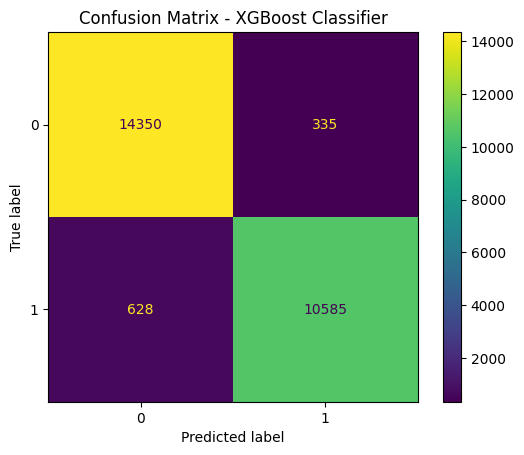

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     14685
           1       0.97      0.94      0.96     11213

    accuracy                           0.96     25898
   macro avg       0.96      0.96      0.96     25898
weighted avg       0.96      0.96      0.96     25898

Accuracy Score: 0.9628156614410379


In [20]:
y_pred = model_pipeline.predict(X_test)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
disp.plot()
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

### **Fine tuning model**

In [21]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__eval_metric': ['logloss', 'error', 'auc']
}

grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=5, 
    scoring='accuracy',  
    n_jobs=-1, 
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

test_accuracy = best_model.score(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


KeyboardInterrupt: 